# Example 4: Hierarchical risk parity

This example follows from previous ones. If something in the preamble is confusing, it is explained there.

This example focuses on the `HRP` optimisation type of `HCPortfolio`.

## 4.1 Downloading the data

In [1]:
# using Pkg
# Pkg.add.(["StatsPlots", "GraphRecipes", "YFinance", "Clarabel", "HiGHS", "CovarianceEstimation", "SparseArrays"])
using Clarabel, CovarianceEstimation, DataFrames, Dates, GraphRecipes, HiGHS, YFinance,
      PortfolioOptimiser, Statistics, StatsBase, StatsPlots, TimeSeries, LinearAlgebra,
      PrettyTables

fmt1 = (v, i, j) -> begin
    if j == 1
        return v
    else
        return if isa(v, Number)
            "$(round(v*100, digits=3)) %"
        else
            v
        end
    end
end;

function stock_price_to_time_array(x)
    coln = collect(keys(x))[3:end] # only get the keys that are not ticker or datetime
    m = hcat([x[k] for k ∈ coln]...) #Convert the dictionary into a matrix
    return TimeArray(x["timestamp"], m, Symbol.(coln), x["ticker"])
end
assets = ["AAL", "AAPL", "AMC", "BB", "BBY", "DELL", "DG", "DRS", "GME", "INTC", "LULU",
          "MARA", "MCI", "MSFT", "NKLA", "NVAX", "NVDA", "PARA", "PLNT", "SAVE", "SBUX",
          "SIRI", "STX", "TLRY", "TSLA"]
Date_0 = "2019-01-01"
Date_1 = "2023-01-01"
prices = get_prices.(assets; startdt = Date_0, enddt = Date_1)
prices = stock_price_to_time_array.(prices)
prices = hcat(prices...)
cidx = colnames(prices)[occursin.(r"adj", string.(colnames(prices)))]
prices = prices[cidx]
TimeSeries.rename!(prices, Symbol.(assets));

## 4.2 Instantiating an instance of `HCPortfolio`.

Since we're going to be performing `HRP` optimisations, we only need `solvers` for entropic and relativistic risk measures. Others don't make use of a solver, they can be computed from the asset statistics.

In [2]:
portfolio = HCPortfolio(; prices = prices,
                        # Continuous optimiser.
                        solvers = Dict(:Clarabel => Dict(:solver => Clarabel.Optimizer,
                                                         :check_sol => (allow_local = true,
                                                                        allow_almost = true),
                                                         :params => Dict("verbose" => false))),
                        # MIP optimiser for the discrete allocation.
                        alloc_solvers = Dict(:HiGHS => Dict(:solver => HiGHS.Optimizer,
                                                            :check_sol => (allow_local = true,
                                                                           allow_almost = true),
                                                            :params => Dict("log_to_console" => false))));

We will first use the most basic statistics. We'll later see how we can change the characteristics by changing them.

In [3]:
cov_type = PortCovCor()
cor_type = PortCovCor()
dist_type = DistCanonical()
asset_statistics!(portfolio; cov_type = cov_type, cor_type = cor_type,
                  dist_type = dist_type)

# 4.3 Basic HRP portfolio

## 4.3.1 Hierarchical clustering

All [`HCPortfolio`]s use the assets' correlation structure to optimise the portfolios based on their correlation structure. [`PortfolioOptimiser`](https://github.com/dcelisgarza/PortfolioOptimiser.jl) comes with two clustering methods.

- Hierarchical clustering using [`Clustering.jl`](https://github.com/JuliaStats/Clustering.jl).
- [`Direct Bubble Hierarchy Trees`](https://uk.mathworks.com/matlabcentral/fileexchange/46750-dbht).

We'll use the default values for everything, see `optimise!` for details.

In [4]:
# Standard deviation
rm = SD()

# Hierachical clustering with Ward's linkage.
hclust_alg = HAC(; linkage = :ward)
# Method for determining the number of clusters is the two-difference gap statistic `TwoDiff`.
hclust_opt = HCOpt(; k_method = TwoDiff())
cluster_assets!(portfolio; hclust_alg = hclust_alg, hclust_opt = hclust_opt)

# Optimise.
w1 = optimise!(portfolio; rm = rm)
pretty_table(w1; formatters = fmt1)

┌─────────┬─────────┐
│ tickers │ weights │
│  String │ Float64 │
├─────────┼─────────┤
│     AAL │ 2.041 % │
│    AAPL │ 4.484 % │
│     AMC │  0.83 % │
│      BB │ 2.675 % │
│     BBY │ 4.114 % │
│    DELL │  6.61 % │
│      DG │ 11.12 % │
│     DRS │ 3.301 % │
│     GME │ 1.042 % │
│    INTC │ 3.853 % │
│    LULU │ 6.338 % │
│    MARA │ 1.301 % │
│     MCI │ 8.422 % │
│    MSFT │ 4.891 % │
│    NKLA │ 1.849 % │
│    NVAX │ 1.478 % │
│    NVDA │ 5.579 % │
│    PARA │ 5.229 % │
│    PLNT │ 2.849 % │
│    SAVE │ 1.897 % │
│    SBUX │ 4.572 % │
│    SIRI │ 5.713 % │
│     STX │ 3.819 % │
│    TLRY │ 2.921 % │
│    TSLA │ 3.072 % │
└─────────┴─────────┘


`HRP` uses the clustering structure, but it splits the dendrogram naïvely down the middle. This means it can't take full advantage of the clustering structure, and may split closely related assets into separate clusters, which is not ideal. However, the next example will go over the `HERC` optimisation type, which does consider the clustering structure.

Regardless, we'll plot the clusters to see the structure of the relationships between assets. We don't want to clusterise again so we'll set `cluster = false`, which is also a flag in `optimise!`, which saves on processing when the assets have been previously clusterised, the default is `cluster = true`.

┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots C:\Users\Daniel Celis Garza\.julia\packages\Plots\kLeqV\src\args.jl:1552


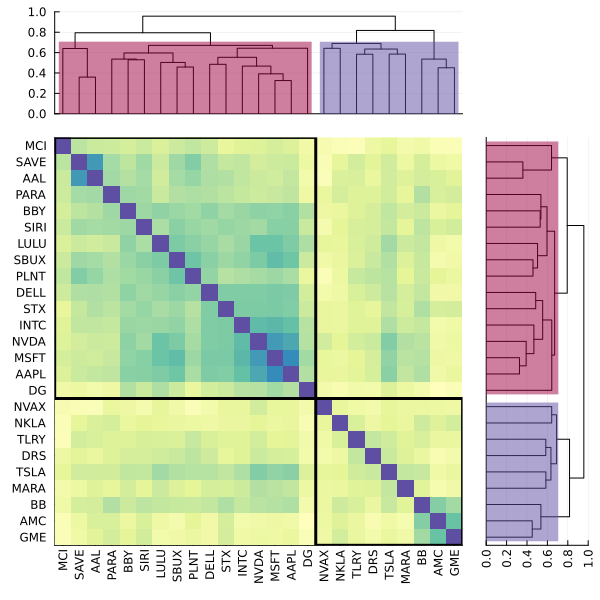

In [5]:
display(plot_clusters(portfolio; cluster = false))

Before moving on to DBHT clustering, we'll use a different linkage function. Generally speaking, Ward's clustering is the most robust when dealing with noisy data, which is why it's the default method. Lets see what complete clustering looks like. And now we'll use a different method for determining the clusters, `StdSilhouette`.

┌─────────┬─────────┐
│ tickers │ weights │
│  String │ Float64 │
├─────────┼─────────┤
│     AAL │ 2.078 % │
│    AAPL │ 3.997 % │
│     AMC │ 0.836 % │
│      BB │ 4.481 % │
│     BBY │ 4.189 % │
│    DELL │ 6.508 % │
│      DG │ 8.068 % │
│     DRS │  3.26 % │
│     GME │  1.05 % │
│    INTC │ 3.793 % │
│    LULU │ 4.269 % │
│    MARA │ 1.487 % │
│     MCI │ 8.576 % │
│    MSFT │  4.36 % │
│    NKLA │ 1.967 % │
│    NVAX │ 1.572 % │
│    NVDA │ 4.973 % │
│    PARA │ 5.324 % │
│    PLNT │ 5.978 % │
│    SAVE │ 1.932 % │
│    SBUX │ 5.474 % │
│    SIRI │ 5.818 % │
│     STX │  3.76 % │
│    TLRY │ 1.789 % │
│    TSLA │ 4.462 % │
└─────────┴─────────┘


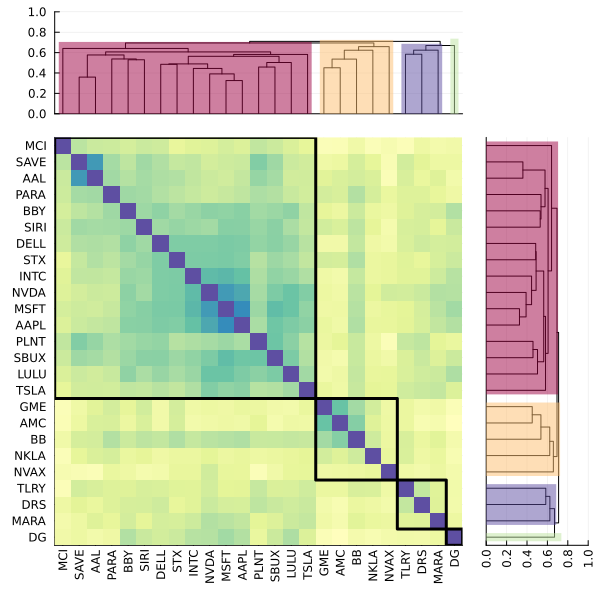

In [6]:
# Hierarchical clustering with complete linkage.
hclust_alg = HAC(; linkage = :complete)
# Method for determining the number of clusters is the Standard silhouette score `StdSilhouette`.
hclust_opt = HCOpt(; k_method = StdSilhouette())
cluster_assets!(portfolio; hclust_alg = hclust_alg, hclust_opt = hclust_opt)

# Optimise.
w2 = optimise!(portfolio; rm = rm)
pretty_table(w2; formatters = fmt1)
display(plot_clusters(portfolio; cluster = false))

## 4.3.2 DBHT clustering

Direct Bubble Hierarchy Tree (DBHT) clustering, is a type of clustering based on graph-theoretic filtering. The same idea is used to compute the `LoGo` covariance, which we explored in [Example 2](https://github.com/dcelisgarza/PortfolioOptimiser.jl/blob/main/examples/2_asset_statistics.jl).

DBHT clustering also uses a similarity matrix, the original `MATLAB` code proposes two methods. [`PortfolioOptimiser`](https://github.com/dcelisgarza/PortfolioOptimiser.jl) implements them both using `DBHTMaxDist` and `DBHTExp`. Though users can define their own creating a concrete subtype of `PortfolioOptimiser.DBHTSimilarity` and implementing `dbht_similarity` for it. There are also two methods for defining roots of graphs, either of which can be used `UniqueDBHT` and `EqualDBHT`.

For now we will use teh defaults.

Again we will use default parameters first. We're not setting `cluster = flase` in this optimisation since we want the assets to be clustered using this new algorithm.

In [7]:
# DBHT clustering, using the distance from the maximum value of the dissimilarity matrix `DBHTMaxDist`.
hclust_alg = DBHT(; similarity = DBHTMaxDist())
hclust_opt = HCOpt(; k_method = TwoDiff())
cluster_assets!(portfolio; hclust_alg = hclust_alg, hclust_opt = hclust_opt)
w3 = optimise!(portfolio; rm = rm)
pretty_table(w3; formatters = fmt1)

┌─────────┬─────────┐
│ tickers │ weights │
│  String │ Float64 │
├─────────┼─────────┤
│     AAL │  2.27 % │
│    AAPL │  5.57 % │
│     AMC │ 0.846 % │
│      BB │ 4.708 % │
│     BBY │ 3.622 % │
│    DELL │ 3.815 % │
│      DG │ 6.236 % │
│     DRS │ 2.698 % │
│     GME │ 1.062 % │
│    INTC │ 4.336 % │
│    LULU │ 4.649 % │
│    MARA │ 2.234 % │
│     MCI │  5.67 % │
│    MSFT │ 8.217 % │
│    NKLA │ 2.856 % │
│    NVAX │ 1.313 % │
│    NVDA │ 3.317 % │
│    PARA │ 2.692 % │
│    PLNT │ 5.237 % │
│    SAVE │ 2.384 % │
│    SBUX │ 8.554 % │
│    SIRI │ 8.434 % │
│     STX │  4.91 % │
│    TLRY │ 1.481 % │
│    TSLA │  2.89 % │
└─────────┴─────────┘


We will again plot the clusters. Note how different the clusters are.

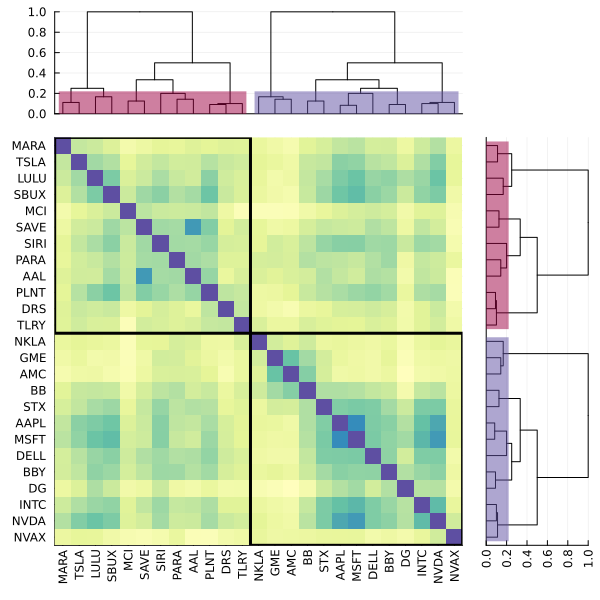

In [8]:
display(plot_clusters(portfolio; cluster = false))

Now we'll see the effect changing the similarity matrix calculation to exponential decay of the disimilarity score.

┌─────────┬─────────┐
│ tickers │ weights │
│  String │ Float64 │
├─────────┼─────────┤
│     AAL │ 2.262 % │
│    AAPL │ 4.326 % │
│     AMC │ 1.696 % │
│      BB │ 2.134 % │
│     BBY │  3.58 % │
│    DELL │ 3.844 % │
│      DG │ 7.692 % │
│     DRS │ 3.179 % │
│     GME │ 1.337 % │
│    INTC │ 6.784 % │
│    LULU │ 5.578 % │
│    MARA │ 2.343 % │
│     MCI │ 5.817 % │
│    MSFT │ 8.168 % │
│    NKLA │ 2.015 % │
│    NVAX │ 2.964 % │
│    NVDA │ 3.958 % │
│    PARA │ 3.121 % │
│    PLNT │ 3.801 % │
│    SAVE │ 2.102 % │
│    SBUX │ 4.686 % │
│    SIRI │ 8.414 % │
│     STX │ 3.882 % │
│    TLRY │ 2.851 % │
│    TSLA │ 3.468 % │
└─────────┴─────────┘


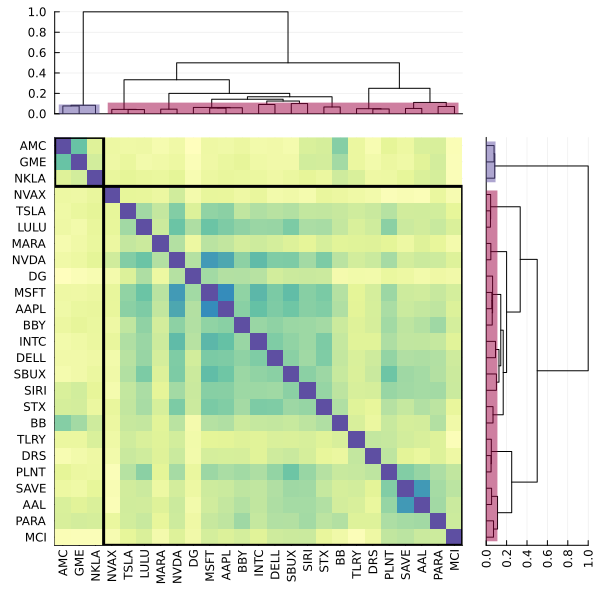

In [9]:
hclust_alg = DBHT(; similarity = DBHTExp())
hclust_opt = HCOpt(; k_method = TwoDiff())
cluster_assets!(portfolio; hclust_alg = hclust_alg, hclust_opt = hclust_opt)

w4 = optimise!(portfolio; rm = rm)
pretty_table(w4; formatters = fmt1)
display(plot_clusters(portfolio; cluster = false))

Now we'll define our own method for the similarity matrix. We'll use one of the potential definitions given in `DBHTs`.

As a general rule, [`PortfolioOptimiser`](https://github.com/dcelisgarza/PortfolioOptimiser.jl) doesn't export abstract types, so they have to be explicitly imported.

We'll define our similarity matrix using only the correlation, denoted here by `S`, the distance matrix is denoted by `D` `dbht_similarity`.

┌─────────┬─────────┐
│ tickers │ weights │
│  String │ Float64 │
├─────────┼─────────┤
│     AAL │  2.33 % │
│    AAPL │ 4.492 % │
│     AMC │ 1.572 % │
│      BB │ 3.032 % │
│     BBY │ 3.717 % │
│    DELL │   3.9 % │
│      DG │ 6.104 % │
│     DRS │ 3.275 % │
│     GME │ 1.239 % │
│    INTC │ 6.915 % │
│    LULU │ 3.955 % │
│    MARA │ 2.452 % │
│     MCI │ 5.993 % │
│    MSFT │ 8.676 % │
│    NKLA │ 1.868 % │
│    NVAX │ 1.359 % │
│    NVDA │ 3.433 % │
│    PARA │ 3.215 % │
│    PLNT │ 3.916 % │
│    SAVE │ 2.166 % │
│    SBUX │ 4.754 % │
│    SIRI │ 8.894 % │
│     STX │ 5.517 % │
│    TLRY │ 2.937 % │
│    TSLA │ 4.289 % │
└─────────┴─────────┘


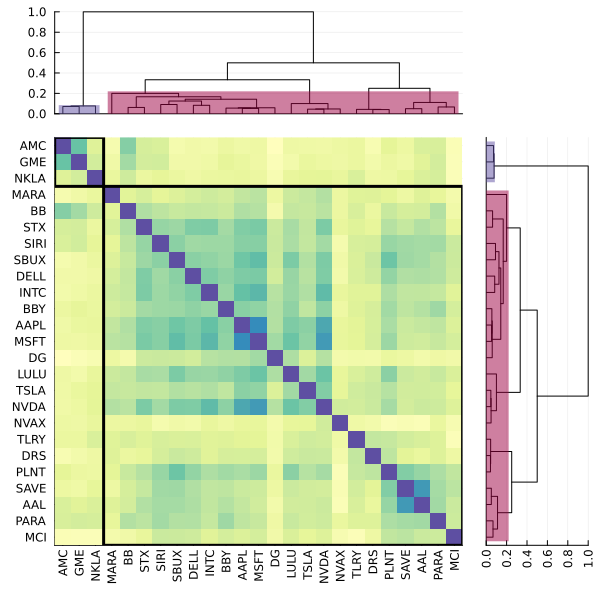

In [10]:
struct DBHTClamp <: PortfolioOptimiser.DBHTSimilarity end
function PortfolioOptimiser.dbht_similarity(::DBHTClamp, S, D)
    return S .+ abs(minimum(S))
end
hclust_alg = DBHT(; similarity = DBHTClamp())
hclust_opt = HCOpt(; k_method = TwoDiff())
cluster_assets!(portfolio; hclust_alg = hclust_alg, hclust_opt = hclust_opt)

w5 = optimise!(portfolio; rm = rm)
pretty_table(w5; formatters = fmt1)
display(plot_clusters(portfolio; cluster = false))

We'll make another method that uses both the correlation and distance matrices to create the DBHT similarity matrix. We'll also make it tuneable.

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│     AAL │  2.686 % │
│    AAPL │    7.2 % │
│     AMC │  1.101 % │
│      BB │  2.241 % │
│     BBY │  3.653 % │
│    DELL │  3.798 % │
│      DG │  5.763 % │
│     DRS │  5.387 % │
│     GME │  2.355 % │
│    INTC │  6.422 % │
│    LULU │  3.735 % │
│    MARA │   1.09 % │
│     MCI │ 10.105 % │
│    MSFT │  4.753 % │
│    NKLA │  2.316 % │
│    NVAX │  1.851 % │
│    NVDA │  2.727 % │
│    PARA │  5.447 % │
│    PLNT │  3.403 % │
│    SAVE │  2.513 % │
│    SBUX │   4.69 % │
│    SIRI │  5.945 % │
│     STX │  6.743 % │
│    TLRY │  1.942 % │
│    TSLA │  2.135 % │
└─────────┴──────────┘


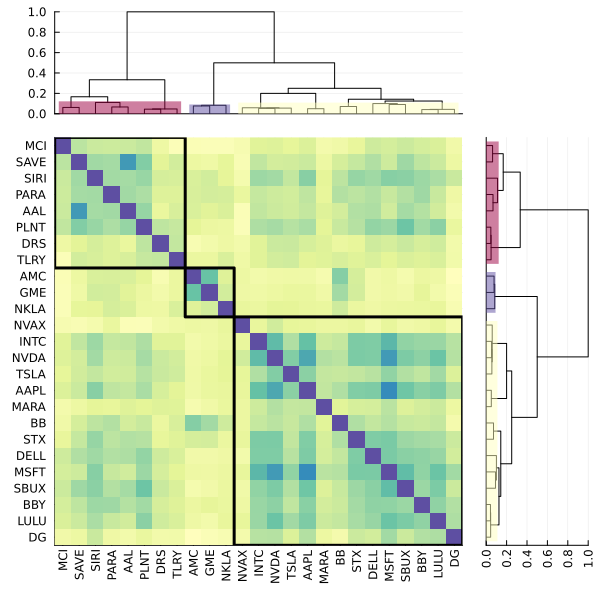

In [11]:
@kwdef mutable struct DBHTTuneableLinComboMaxDistExp{T1 <: Real, T2 <: Real, T3 <: Real} <:
                      PortfolioOptimiser.DBHTSimilarity
    maxdist_c::T1 = 1.0
    expdeca_c::T2 = 1.0
    argcoef::T3 = 0.5
end
function PortfolioOptimiser.dbht_similarity(DBHT::DBHTTuneableLinComboMaxDistExp, S, D)
    max_dist = DBHT.maxdist_c * PortfolioOptimiser.dbht_similarity(DBHTMaxDist(), S, D)
    exp_dec = exp.(-DBHT.argcoef * D)
    return max_dist + exp_dec
end
hclust_alg = DBHT(;
                  similarity = DBHTTuneableLinComboMaxDistExp(; maxdist_c = 0.3,
                                                              expdeca_c = 1, argcoef = 0.4))
hclust_opt = HCOpt(; k_method = TwoDiff())
cluster_assets!(portfolio; hclust_alg = hclust_alg, hclust_opt = hclust_opt)

w6 = optimise!(portfolio; rm = rm)
pretty_table(w6; formatters = fmt1)
display(plot_clusters(portfolio; cluster = false))

## 4.3.3 Using detoned matrices.

As mentioned in [Example 2](https://github.com/dcelisgarza/PortfolioOptimiser.jl/blob/main/examples/2_asset_statistics.jl), detoned matrices can be of great value in hierarchical optimisations. We'll see their effect here.

We will repeat the exact same steps as above, but without redefining the structures.

In [12]:
cov_type = PortCovCor(; denoise = DenoiseFixed(; detone = true))
cor_type = PortCovCor(; denoise = DenoiseFixed(; detone = true))
dist_type = DistCanonical()
asset_statistics!(portfolio; cov_type = cov_type, cor_type = cor_type,
                  dist_type = dist_type)

First we try Ward's linkage.

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│     AAL │  1.499 % │
│    AAPL │  9.037 % │
│     AMC │  0.469 % │
│      BB │  1.491 % │
│     BBY │  5.325 % │
│    DELL │  5.832 % │
│      DG │  5.374 % │
│     DRS │  1.551 % │
│     GME │  0.952 % │
│    INTC │  4.793 % │
│    LULU │  4.718 % │
│    MARA │  0.665 % │
│     MCI │  4.744 % │
│    MSFT │ 10.364 % │
│    NKLA │  0.945 % │
│    NVAX │  0.739 % │
│    NVDA │  4.226 % │
│    PARA │  3.482 % │
│    PLNT │  3.806 % │
│    SAVE │  1.381 % │
│    SBUX │ 10.414 % │
│    SIRI │ 10.105 % │
│     STX │  5.555 % │
│    TLRY │  0.864 % │
│    TSLA │   1.67 % │
└─────────┴──────────┘


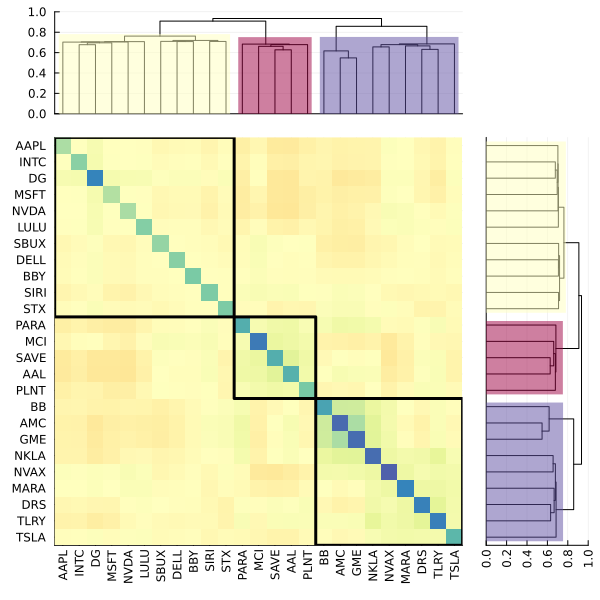

In [13]:
hclust_alg = HAC(; linkage = :ward)
hclust_opt = HCOpt(; k_method = TwoDiff())
cluster_assets!(portfolio; hclust_alg = hclust_alg, hclust_opt = hclust_opt)

w7 = optimise!(portfolio; rm = rm)
pretty_table(w7; formatters = fmt1)
display(plot_clusters(portfolio; cluster = false))

Then complete, and we'll see categorise the number of clusters according to the standard silhouette score.

┌─────────┬─────────┐
│ tickers │ weights │
│  String │ Float64 │
├─────────┼─────────┤
│     AAL │ 2.047 % │
│    AAPL │ 6.864 % │
│     AMC │ 0.443 % │
│      BB │ 2.392 % │
│     BBY │ 6.964 % │
│    DELL │ 5.419 % │
│      DG │ 6.448 % │
│     DRS │ 4.103 % │
│     GME │ 0.558 % │
│    INTC │ 5.469 % │
│    LULU │ 5.257 % │
│    MARA │ 1.352 % │
│     MCI │ 6.675 % │
│    MSFT │ 7.699 % │
│    NKLA │  2.02 % │
│    NVAX │ 0.931 % │
│    NVDA │ 4.461 % │
│    PARA │ 2.762 % │
│    PLNT │ 4.623 % │
│    SAVE │ 1.886 % │
│    SBUX │ 6.862 % │
│    SIRI │ 5.749 % │
│     STX │ 5.129 % │
│    TLRY │ 1.152 % │
│    TSLA │ 2.736 % │
└─────────┴─────────┘


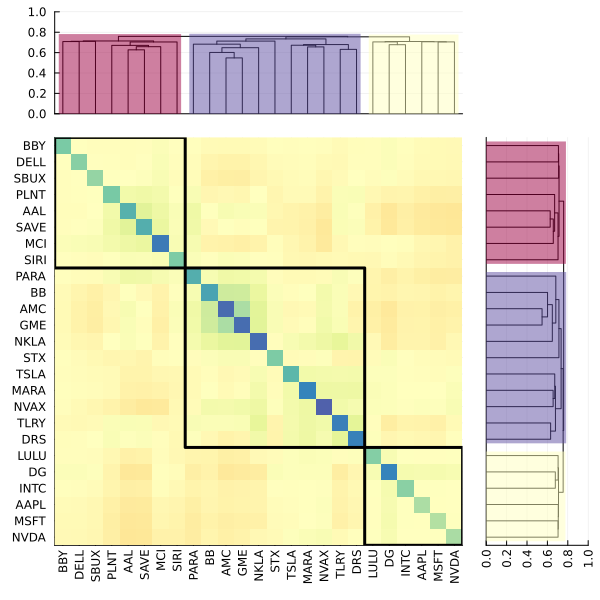

In [14]:
hclust_alg = HAC(; linkage = :complete)
hclust_opt = HCOpt(; k_method = StdSilhouette())
cluster_assets!(portfolio; hclust_alg = hclust_alg, hclust_opt = hclust_opt)

w8 = optimise!(portfolio; rm = rm)
pretty_table(w8; formatters = fmt1)
display(plot_clusters(portfolio; cluster = false))

Now we'll use DBHT clustering with max distance similarity.

┌─────────┬─────────┐
│ tickers │ weights │
│  String │ Float64 │
├─────────┼─────────┤
│     AAL │ 1.931 % │
│    AAPL │ 7.076 % │
│     AMC │ 0.818 % │
│      BB │ 2.061 % │
│     BBY │ 7.364 % │
│    DELL │   4.4 % │
│      DG │ 5.766 % │
│     DRS │  2.83 % │
│     GME │ 1.223 % │
│    INTC │ 7.488 % │
│    LULU │ 5.366 % │
│    MARA │ 1.739 % │
│     MCI │ 4.485 % │
│    MSFT │ 7.968 % │
│    NKLA │ 1.881 % │
│    NVAX │ 0.963 % │
│    NVDA │ 6.551 % │
│    PARA │  3.69 % │
│    PLNT │ 3.298 % │
│    SAVE │ 1.779 % │
│    SBUX │ 5.739 % │
│    SIRI │ 7.108 % │
│     STX │ 4.915 % │
│    TLRY │ 1.214 % │
│    TSLA │ 2.347 % │
└─────────┴─────────┘


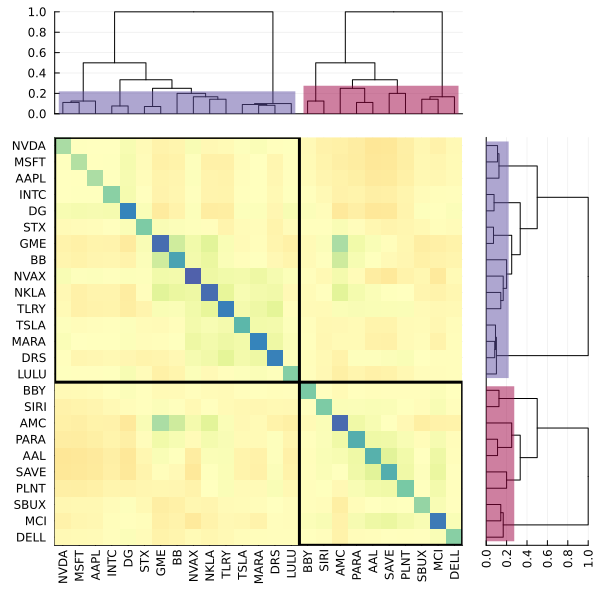

In [15]:
hclust_alg = DBHT(; similarity = DBHTMaxDist())
hclust_opt = HCOpt(; k_method = TwoDiff())
cluster_assets!(portfolio; hclust_alg = hclust_alg, hclust_opt = hclust_opt)

w9 = optimise!(portfolio; rm = rm)
pretty_table(w9; formatters = fmt1)
display(plot_clusters(portfolio; cluster = false))

Now we'll use the exponential decay similarity.

┌─────────┬─────────┐
│ tickers │ weights │
│  String │ Float64 │
├─────────┼─────────┤
│     AAL │ 2.011 % │
│    AAPL │  6.53 % │
│     AMC │ 0.494 % │
│      BB │ 2.126 % │
│     BBY │ 4.977 % │
│    DELL │ 7.224 % │
│      DG │ 5.833 % │
│     DRS │ 2.901 % │
│     GME │ 0.622 % │
│    INTC │ 5.485 % │
│    LULU │  4.91 % │
│    MARA │ 1.747 % │
│     MCI │ 4.988 % │
│    MSFT │ 7.752 % │
│    NKLA │  1.27 % │
│    NVAX │ 1.539 % │
│    NVDA │ 4.926 % │
│    PARA │ 4.724 % │
│    PLNT │ 4.542 % │
│    SAVE │ 1.853 % │
│    SBUX │ 6.196 % │
│    SIRI │ 6.983 % │
│     STX │  5.59 % │
│    TLRY │ 2.039 % │
│    TSLA │ 2.738 % │
└─────────┴─────────┘


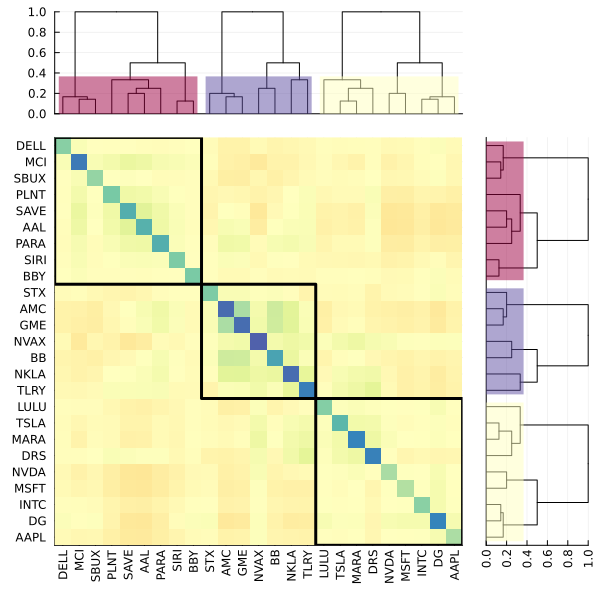

In [16]:
hclust_alg = DBHT(; similarity = DBHTExp())
hclust_opt = HCOpt(; k_method = TwoDiff())
cluster_assets!(portfolio; hclust_alg = hclust_alg, hclust_opt = hclust_opt)

w10 = optimise!(portfolio; rm = rm)
pretty_table(w10; formatters = fmt1)
display(plot_clusters(portfolio; cluster = false))

Now we'll try the clamp method.

┌─────────┬─────────┐
│ tickers │ weights │
│  String │ Float64 │
├─────────┼─────────┤
│     AAL │ 1.951 % │
│    AAPL │ 8.438 % │
│     AMC │ 1.338 % │
│      BB │ 1.812 % │
│     BBY │ 4.701 % │
│    DELL │ 7.008 % │
│      DG │ 5.963 % │
│     DRS │ 1.916 % │
│     GME │ 0.718 % │
│    INTC │ 8.056 % │
│    LULU │  5.73 % │
│    MARA │ 0.872 % │
│     MCI │ 4.839 % │
│    MSFT │ 7.517 % │
│    NKLA │ 1.777 % │
│    NVAX │ 0.923 % │
│    NVDA │ 3.544 % │
│    PARA │ 4.462 % │
│    PLNT │ 4.407 % │
│    SAVE │ 1.797 % │
│    SBUX │ 6.011 % │
│    SIRI │ 6.595 % │
│     STX │ 6.425 % │
│    TLRY │ 1.048 % │
│    TSLA │ 2.151 % │
└─────────┴─────────┘


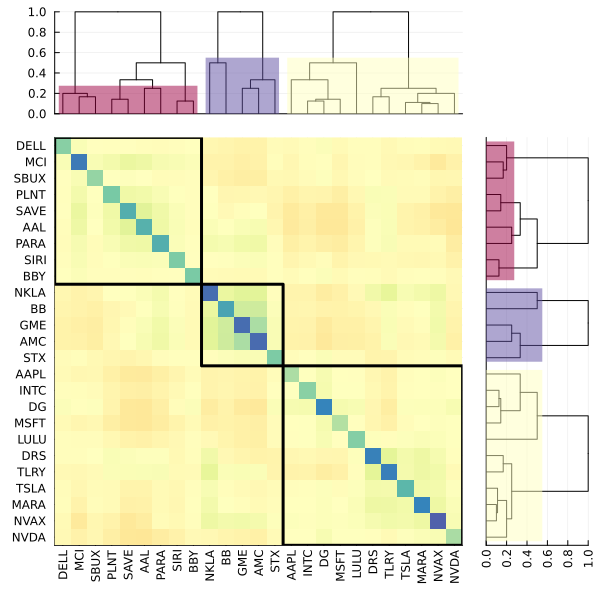

In [17]:
hclust_alg = DBHT(; similarity = DBHTClamp())
hclust_opt = HCOpt(; k_method = TwoDiff())
cluster_assets!(portfolio; hclust_alg = hclust_alg, hclust_opt = hclust_opt)

w11 = optimise!(portfolio; rm = rm)
pretty_table(w11; formatters = fmt1)
display(plot_clusters(portfolio; cluster = false))

And finally the tuneable linear combination of max distance and exponential decay.

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│     AAL │  1.908 % │
│    AAPL │ 10.433 % │
│     AMC │  0.489 % │
│      BB │  1.556 % │
│     BBY │  5.733 % │
│    DELL │  6.854 % │
│      DG │  6.204 % │
│     DRS │  2.166 % │
│     GME │  0.693 % │
│    INTC │  5.533 % │
│    LULU │  4.107 % │
│    MARA │  0.851 % │
│     MCI │  4.732 % │
│    MSFT │  9.106 % │
│    NKLA │  1.341 % │
│    NVAX │   1.43 % │
│    NVDA │  4.029 % │
│    PARA │  5.442 % │
│    PLNT │   4.31 % │
│    SAVE │  1.758 % │
│    SBUX │  5.878 % │
│    SIRI │  8.044 % │
│     STX │  3.659 % │
│    TLRY │  1.644 % │
│    TSLA │  2.099 % │
└─────────┴──────────┘


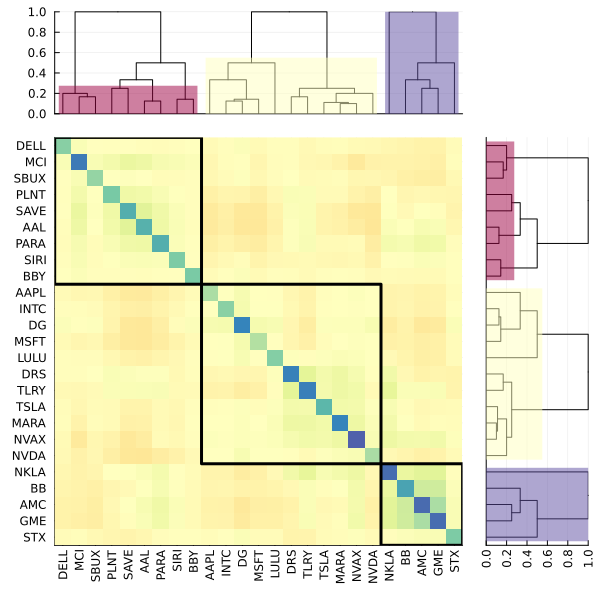

In [18]:
hclust_alg = DBHT(;
                  similarity = DBHTTuneableLinComboMaxDistExp(; maxdist_c = 0.3,
                                                              expdeca_c = 1, argcoef = 0.4))
hclust_opt = HCOpt(; k_method = TwoDiff())
cluster_assets!(portfolio; hclust_alg = hclust_alg, hclust_opt = hclust_opt)

w12 = optimise!(portfolio; rm = rm)
pretty_table(w12; formatters = fmt1)
display(plot_clusters(portfolio; cluster = false))

As you can see, there are drastic differences in the correlation matrices. We'll display the weights of the sample  correlations and covariances (:weights) and their detoned counterparts (:weights_d) side by side.

In [19]:
# Ward's linkage
pretty_table(DataFrames.rename!(hcat(w1, w7.weights), :x1 => :weights_d); formatters = fmt1)
# complete linkage
pretty_table(DataFrames.rename!(hcat(w2, w8.weights), :x1 => :weights_d); formatters = fmt1)
# DBHT max dist
pretty_table(DataFrames.rename!(hcat(w3, w9.weights), :x1 => :weights_d); formatters = fmt1)
# DBHT exp decay
pretty_table(DataFrames.rename!(hcat(w4, w10.weights), :x1 => :weights_d);
             formatters = fmt1)
# DBHT clamp (custom method)
pretty_table(DataFrames.rename!(hcat(w5, w11.weights), :x1 => :weights_d);
             formatters = fmt1)
# DBHT tuneable linear combination max dist exp decay
pretty_table(DataFrames.rename!(hcat(w6, w12.weights), :x1 => :weights_d);
             formatters = fmt1)

┌─────────┬─────────┬───────────┐
│ tickers │ weights │ weights_d │
│  String │ Float64 │   Float64 │
├─────────┼─────────┼───────────┤
│     AAL │ 2.041 % │   1.499 % │
│    AAPL │ 4.484 % │   9.037 % │
│     AMC │  0.83 % │   0.469 % │
│      BB │ 2.675 % │   1.491 % │
│     BBY │ 4.114 % │   5.325 % │
│    DELL │  6.61 % │   5.832 % │
│      DG │ 11.12 % │   5.374 % │
│     DRS │ 3.301 % │   1.551 % │
│     GME │ 1.042 % │   0.952 % │
│    INTC │ 3.853 % │   4.793 % │
│    LULU │ 6.338 % │   4.718 % │
│    MARA │ 1.301 % │   0.665 % │
│     MCI │ 8.422 % │   4.744 % │
│    MSFT │ 4.891 % │  10.364 % │
│    NKLA │ 1.849 % │   0.945 % │
│    NVAX │ 1.478 % │   0.739 % │
│    NVDA │ 5.579 % │   4.226 % │
│    PARA │ 5.229 % │   3.482 % │
│    PLNT │ 2.849 % │   3.806 % │
│    SAVE │ 1.897 % │   1.381 % │
│    SBUX │ 4.572 % │  10.414 % │
│    SIRI │ 5.713 % │  10.105 % │
│     STX │ 3.819 % │   5.555 % │
│    TLRY │ 2.921 % │   0.864 % │
│    TSLA │ 3.072 % │    1.67 % │
└─────────┴───

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*